In [1]:
import os
import pandas as pd
import numpy as np

import ast

from fontTools.ttLib import TTFont
from fontTools.pens.svgPathPen import SVGPathPen

import svgpath2mpl
from svgpath2mpl import parse_path
from svgutils.compose import *

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

In [2]:
fdir = '../ff/'
#os.listdir(fdir)
fnam = 'ff_c1.ttf'
font = TTFont(fdir+fnam)
cmap = font.getBestCmap()
cmapv = list(cmap.values())
# cmap

In [3]:
with open('cdict1.txt') as f:
    data = f.read()
cdict = ast.literal_eval(data)
clist = list(cdict.keys())
#cdict['ū']

In [4]:
tdir = '../../Generative/chatgpt/'
tfil = '李雪遗传学研究_9.txt'
#sorted(os.listdir(tdir))
#
my_tfil = open(tdir+tfil, "r")
data = my_tfil.read()
my_tfil.close()
data = data.split("\n")
data = [d for d in data if d != "#"]
data = [d for d in data if d != "# ~~~~~~~~~~"]
#data
#
pind = [i for i in range(len(data)) if "# pg" in data[i]]
pages = [data[pind[ii]:pind[ii+1]] for ii in range(len(pind)-1)]
#pages[4]

In [5]:
for p in range(len(pages)):
    pp = p

In [6]:
pp = 18 ## set page
txts = pages[pp]
pg = [t for t in txts if "# pg" in t]
pg = pg[0].replace("# ","")
txts = [t for t in txts if "# pg" not in t]
txts

['她走到餐厅，',
 'Tā zǒu dào cāntīng,',
 '和一位同事聊天。',
 'hé yī wèi tóngshì liáotiān.',
 'She went to the canteen',
 'and talked to a colleague.',
 '她的同事叫张博。',
 'Tā de tóngshì jiào Zhāng Bó.',
 'Her colleague is called Zhang Bo.',
 '她和同事聊着他们最近的',
 'Tā hé tóngshì liáozhe tāmen zuìjìn de',
 '研究进展，',
 'yánjiū jìnzhǎn,',
 '并互相交流想法。',
 'bìng hù xiàng jiāoliú xiǎngfǎ.',
 'They talked about their recent',
 'research progress',
 'and exchanged ideas.']

In [7]:
# size correction
# english, punctuation, pinyin, hanzi
csca = {
    "engl": 1,
    "punc": 1,
    "piny": 1,
    "hanz": 1.75,
}
csca["engl"]
#
tcs = []
ics = []
pg_miss_c = []
for x in range(len(txts)):
    txt = txts[x]
    tc = []
    ic = []
    for t in range(len(txt)):
        char = txt[t]
        charr = char.encode("unicode_escape")
        charr = str(charr)
        ctyp = ""
        if len(charr) <5:
            if char in clist: # English
                charrie = cdict[char]
                ctyp = "engl"
            else: # Common punctuation
                charrie = char
                ctyp = "punc"
        else:
            if char in clist: # Pinyin symbols
                charrie = cdict[char]                    
                ctyp = "piny"
            else: # Chinese characters
                charr = charr.replace("b'\\\\","'\\\\")
                charr = charr.replace("'","")
                charr = charr.replace("\\\\","")
                charr = charr.upper()
                charrie = charr.replace("U","uni")                  
                ctyp = "hanz"
                if charrie not in cmapv:
                    pg_miss_c.append(char)                    
        tc.append(csca[ctyp])
        ic.append(charrie)
    tcs.append(tc)
    ics.append(ic)

In [8]:
print('custom font')
print('no of chars: '+str(len(cmapv)))

custom font
no of chars: 412


In [9]:
print('missing characters')
print(len(set(pg_miss_c)))
set(pg_miss_c)

missing characters
18


{'事',
 '互',
 '交',
 '他',
 '位',
 '博',
 '厅',
 '同',
 '天',
 '展',
 '张',
 '最',
 '流',
 '相',
 '聊',
 '走',
 '近',
 '餐'}

0


KeyError: 'uni8D70'

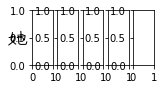

In [10]:
for x in range(len(txts)):
    if x >= 0: # use for subset
        #x = 14
        print(x)
        txt = txts[x]
        # txt='Nǐ hǎo, nǐ zěnme yàng'
        # txt
        sca = 1
        gpx = 10
        gpy = 10
#         print("len:")
#         print(len(txt))
#         print(sum(tcs[x]))
        fig, axs = plt.subplots(1, 
                                len(txt), 
                                figsize=((sum(tcs[x])*sca)/4, sca))
        for t in range(len(txt)):
            char = txt[t]
            charrie = ics[x][t]
            #
            if char != ' ': # Handle spaces
                glyphSet = font.getGlyphSet()
                svgpen = SVGPathPen(glyphSet)
                glyph = glyphSet[charrie]
                #
                glyph.draw(svgpen)
                cpath = svgpen.getCommands()
                cpath = cpath.replace('Z','') # replace 'Z' = 'closepath'
                #cpath
                #
                pcpath = svgpath2mpl.parse_path(cpath)
                vv = pcpath.vertices
                vdf = pd.DataFrame(vv)
                vxmi = vdf[0].min()
                vxma = vdf[0].max()
                vymi = vdf[1].min()
                vyma = vdf[1].max()
                #
                #
                patch = mpl.patches.PathPatch(
                    pcpath, 
                    facecolor='none', 
                    edgecolor='black', 
                    linewidth=1)
                patch.set_transform(axs[t].transData)
                axs[t].add_patch(patch)
                axs[t].set_aspect(1)
                axs[t].axis("off")
                axs[t].set_xticklabels([])
                axs[t].set_yticklabels([])
                axs[t].set_xlim([vxmi-50, vxma+50])
                axs[t].set_ylim([-350, 1100])
            else: # space character
                axs[t].set_aspect(1)
                axs[t].axis("off")
                axs[t].set_xlim([0, 400])
                axs[t].set_ylim([-350, 1100])
        #
        fig.subplots_adjust(left=0, wspace=0, hspace=0)
        fig.patch.set_facecolor('xkcd:mint green')
        plt.savefig("out/phidia3/"+pg+"_l"+str(x)+".svg")
        plt.show()

In [ ]:
txt

In [ ]:
for t in range(len(txts)):
    print(t)
    print(txts[t])

In [ ]:
#txts[0]

In [ ]:
# concatenate page text
#
spp = pg
svgs = sorted(os.listdir('./out/phidia3/'))
svgs = [s for s in svgs if spp in s]
#
s_p0 = 'Figure("0.4cm", "0.4cm",' # not actually cm
s_p1 = 'Panel(SVG("out/phidia3/'
s_p2 = '").scale(0.025)), '
s_pn = ').tile(1,'+str(len(svgs))+').save("out/phidia3/'+spp+'_stack.svg")'
#
s_pl = []
s_pl.append(s_p0)
for s in svgs:
    s_pl.append(s_p1+s+s_p2)
s_pl.append(s_pn)
#
sfun = ''.join(s_pl)
eval(sfun)